In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
%%capture
!apt-get install openslide-tools
!pip install openslide-python

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import re
from google.colab import drive
import json 
from tqdm import tqdm

### Reading Slide Files from Drive

In [3]:
drive.mount('/content/gdrive', force_remount=True)

slides_directory = "/content/gdrive/MyDrive/Applied_DL_Project/slides"

tumor_dictionary = {}

for tif_path in os.listdir(slides_directory):
  if "tif" in tif_path and '38' not in tif_path:
    slide_number = re.findall("tumor_(\d+)",tif_path)
    if slide_number: 
      slide_number = int(slide_number[0])
      if slide_number not in tumor_dictionary: 
        tumor_dictionary[slide_number] = {}
      
      if "mask" not in tif_path:
            tumor_dictionary[slide_number]['tumor'] = os.path.join(slides_directory,tif_path)
      else:
            tumor_dictionary[slide_number]['mask'] = os.path.join(slides_directory,tif_path)


Mounted at /content/gdrive


### Pre-Processing Functions given in Starter Code

In [6]:
# Slide Processing Functions 
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im


# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))


def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked


In [7]:
# Setting Up Test Set.
# Removing Slide 2 because there are not really many tumor patches.
test_set = [91,78,57]

### Custom Image Processing Helper Functions

1. check_center_for_tumor : Check if the center of the path has tumor or not. If tumor present, return True, else False 
2. get_bool_tissue_tumor_pixels : Check if the slide and mask contains tissue and tumor 
3. get_patch  : Get Slide and Mask Patch given the center coordinates and the 
4. generate_dataset : Generate the required Patches 

In [8]:
def check_center_for_tumor(mask, center_len = 128, patch_len = 299):
  """
    "For each input patch, we predict the label of the center 128×128 region " - Authors
  
  Check if the center of the path has tumor or not. If tumor present, return True, else False 

  Input : 
    1. Mask slide  - Mask slide image - shape (299,299)
    2. Center len  - center size (default 128)
    3. patch len  - patch size (default 299) 

  Output : 
    1. Bool - True if tumor present in middle, False if tumor not present 

  """

  start_coordinates = (patch_len - center_len) // 2
  return np.any(mask[start_coordinates : start_coordinates + center_len, start_coordinates : start_coordinates + center_len] > 0 )

In [9]:
def get_patch(slide, mask,x, y, level, patch_size=299,process_mask = False):
  """
  
  Get patch from slide and tumor_mask from given x,y for the given level 

  Input : 
      1. slide - slide
      2. mask  - mask
      3. x - x-co-ordinate
      4. y - y - co-ordinate
      3. level - level 
      3. patch_size - patch_size 

  Output : 
    1. slide_image, mask_image

  """

  half_patch_len = int(patch_size // 2 * slide.level_downsamples[level]) 

  if process_mask: 
    return read_slide(slide,int(x) - half_patch_len,int(y) - half_patch_len, level, width=patch_size,height=patch_size), \
        read_slide(mask, int(x) - half_patch_len,int(y) - half_patch_len, level,width=patch_size,height=patch_size)[:, :, 0]
  else : 
    return read_slide(slide,int(x) - half_patch_len,int(y) - half_patch_len, level, width=patch_size,height=patch_size), None

In [10]:
def create_test_patches(tumor_dictionary,slide_number=2,patch_size = 299 ):

  """

  Generate Patches from test slides 

  Input : 
    tumor_dictionary - dictionary of paths to files 
    levels - levels to use 
    patch_size - size of the square patch extracted from slides

  Outputs:
    X - tuple of length of levels with 4000 patches of different levels.
    Y - Label in terms of "Normal" or "Cancer"

  """

  levels = [3,4,5]

  half_patch_size = patch_size // 2
  
  ##############################################################################

  X_test_data = [[] for _ in levels]

  Y_test_data = [] 

  model_predict = [] 

  print(f"Generating Test Dataset") 

  slide = open_slide(tumor_dictionary[slide_number]['tumor'])
  mask = open_slide(tumor_dictionary[slide_number]['mask'])   
  
  zoom_factor = {x: slide.level_downsamples[x] for x in levels}
  slide_width,slide_height = slide.level_dimensions[3]

  main_zoom_factor = zoom_factor[levels[0]]
  number_of_patches_width = int(slide_width // (patch_size))
  number_of_patches_height = int(slide_height // (patch_size))

  ##############################################################################



  print(f"Number of Patches Width : {number_of_patches_width}, Number of Patches Height : {number_of_patches_height}")
  print(f"Generating {number_of_patches_width*number_of_patches_height} patches")
  for i in range(number_of_patches_width):
    for j in range(number_of_patches_height): 
      if len(X_test_data[0]) and len(X_test_data[0]) % 300 == 0: 
        print(f"Generated {len(X_test_data[0])} patches .... ")
      
      ##############################################################################
      x_coord = ( half_patch_size * slide.level_downsamples[levels[0]]  ) + i * patch_size  * slide.level_downsamples[levels[0]]
      y_coord = ( half_patch_size * slide.level_downsamples[levels[0]] ) + j * patch_size * slide.level_downsamples[levels[0]]

      zoom_image_1, zoom_mask_1 = get_patch(slide, mask, x_coord, y_coord, levels[0],patch_size,process_mask = True)
      zoom_image_2, _ = get_patch(slide, mask, x_coord, y_coord, levels[1], patch_size)
      zoom_image_3, _ = get_patch(slide, mask, x_coord, y_coord, levels[2], patch_size)

      X_test_data[0].append(zoom_image_1)
      X_test_data[1].append(zoom_image_2)
      X_test_data[2].append(zoom_image_3)

      ##############################################################################
      
      tissue_pixels = find_tissue_pixels(zoom_image_1)
      tissue_percentage = float(len(list(tissue_pixels))) / patch_size**2 * 100

      if tissue_percentage > 30 : 
        model_predict.append(1)
        if check_center_for_tumor(zoom_mask_1, 299):
          Y_test_data.append(1)
        else : 
          Y_test_data.append(0)
      else: 
        model_predict.append(0)
        Y_test_data.append(0)

  print(f"Number of tumor : {np.array(model_predict).sum()} , size of all patches {np.array(model_predict).shape}")
  return np.array(X_test_data),np.array(Y_test_data),np.array(model_predict)

In [12]:
! ls -l /content/gdrive/MyDrive/Applied_DL_Project/numpy

total 3928764
-rw------- 1 root root       4128 Dec 21 10:52 label.npy
-rw------- 1 root root       1128 Dec 27 18:26 label_val.npy
-rw------- 1 root root 1072812128 Dec 21 10:51 patch3.npy
-rw------- 1 root root 1072812128 Dec 21 10:52 patch4.npy
-rw------- 1 root root 1072812128 Dec 21 10:52 patch5.npy
-rw------- 1 root root  268203128 Dec 21 11:00 patch_val_3.npy
-rw------- 1 root root  268203128 Dec 27 18:25 patch_val_4.npy
-rw------- 1 root root  268203128 Dec 21 11:00 patch_val_5.npy


In [17]:
slide_number = 91 
X_test_data,Y_test_data,model_predict = create_test_patches(tumor_dictionary,slide_number=slide_number)

print(f"X_test_data : {X_test_data.shape} , Y_test_data : {Y_test_data.shape}, model_predict: {model_predict.shape}")
test_slides_directory = "/content/gdrive/MyDrive/Applied_DL_Project/numpy"

x_name = f"X_test_data_{slide_number}.npy"
y_name = f"Y_test_data_{slide_number}.npy"
model_predict_name = f"model_predict_data_{slide_number}.npy"

np.save(os.path.join(test_slides_directory,x_name), X_test_data)
np.save(os.path.join(test_slides_directory,y_name), Y_test_data)
np.save(os.path.join(test_slides_directory,model_predict_name), model_predict)
! ls -l $test_slides_directory

Generating Test Dataset
Number of Patches Width : 25, Number of Patches Height : 22
Generating 550 patches
Generated 300 patches .... 
Number of tumor : 177 , size of all patches (550,)
X_test_data : (3, 550, 299, 299, 3) , Y_test_data : (550,), model_predict: (550,)
total 4360937
-rw------- 1 root root       4128 Dec 21 10:52 label.npy
-rw------- 1 root root       1128 Dec 27 18:26 label_val.npy
-rw------- 1 root root       4528 Dec 28 00:48 model_predict_data_91.npy
-rw------- 1 root root 1072812128 Dec 21 10:51 patch3.npy
-rw------- 1 root root 1072812128 Dec 21 10:52 patch4.npy
-rw------- 1 root root 1072812128 Dec 21 10:52 patch5.npy
-rw------- 1 root root  268203128 Dec 21 11:00 patch_val_3.npy
-rw------- 1 root root  268203128 Dec 27 18:25 patch_val_4.npy
-rw------- 1 root root  268203128 Dec 21 11:00 patch_val_5.npy
-rw------- 1 root root  442535078 Dec 28 00:48 X_test_data_91.npy
-rw------- 1 root root       4528 Dec 28 00:48 Y_test_data_91.npy


In [18]:
slide_number = 78 
X_test_data,Y_test_data,model_predict = create_test_patches(tumor_dictionary,slide_number=slide_number)

print(f"X_test_data : {X_test_data.shape} , Y_test_data : {Y_test_data.shape}, model_predict: {model_predict.shape}")
test_slides_directory = "/content/gdrive/MyDrive/Applied_DL_Project/numpy"

x_name = f"X_test_data_{slide_number}.npy"
y_name = f"Y_test_data_{slide_number}.npy"
model_predict_name = f"model_predict_data_{slide_number}.npy"

np.save(os.path.join(test_slides_directory,x_name), X_test_data)
np.save(os.path.join(test_slides_directory,y_name), Y_test_data)
np.save(os.path.join(test_slides_directory,model_predict_name), model_predict)
! ls -l $test_slides_directory

Generating Test Dataset
Number of Patches Width : 39, Number of Patches Height : 46
Generating 1794 patches
Generated 300 patches .... 
Generated 600 patches .... 
Generated 900 patches .... 
Generated 1200 patches .... 
Generated 1500 patches .... 
Number of tumor : 607 , size of all patches (1794,)
X_test_data : (3, 1794, 299, 299, 3) , Y_test_data : (1794,), model_predict: (1794,)
total 5770603
-rw------- 1 root root       4128 Dec 21 10:52 label.npy
-rw------- 1 root root       1128 Dec 27 18:26 label_val.npy
-rw------- 1 root root      14480 Dec 28 00:49 model_predict_data_78.npy
-rw------- 1 root root       4528 Dec 28 00:48 model_predict_data_91.npy
-rw------- 1 root root 1072812128 Dec 21 10:51 patch3.npy
-rw------- 1 root root 1072812128 Dec 21 10:52 patch4.npy
-rw------- 1 root root 1072812128 Dec 21 10:52 patch5.npy
-rw------- 1 root root  268203128 Dec 21 11:00 patch_val_3.npy
-rw------- 1 root root  268203128 Dec 27 18:25 patch_val_4.npy
-rw------- 1 root root  268203128 D

In [19]:
slide_number = 57 
X_test_data,Y_test_data,model_predict = create_test_patches(tumor_dictionary,slide_number=slide_number)

print(f"X_test_data : {X_test_data.shape} , Y_test_data : {Y_test_data.shape}, model_predict: {model_predict.shape}")
test_slides_directory = "/content/gdrive/MyDrive/Applied_DL_Project/numpy"

x_name = f"X_test_data_{slide_number}.npy"
y_name = f"Y_test_data_{slide_number}.npy"
model_predict_name = f"model_predict_data_{slide_number}.npy"

np.save(os.path.join(test_slides_directory,x_name), X_test_data)
np.save(os.path.join(test_slides_directory,y_name), Y_test_data)
np.save(os.path.join(test_slides_directory,model_predict_name), model_predict)
! ls -l $test_slides_directory

Generating Test Dataset
Number of Patches Width : 40, Number of Patches Height : 92
Generating 3680 patches
Generated 300 patches .... 
Generated 600 patches .... 
Generated 900 patches .... 
Generated 1200 patches .... 
Generated 1500 patches .... 
Generated 1800 patches .... 
Generated 2100 patches .... 
Generated 2400 patches .... 
Generated 2700 patches .... 
Generated 3000 patches .... 
Generated 3300 patches .... 
Generated 3600 patches .... 
Number of tumor : 135 , size of all patches (3680,)
X_test_data : (3, 3680, 299, 299, 3) , Y_test_data : (3680,), model_predict: (3680,)
total 8662225
-rw------- 1 root root       4128 Dec 21 10:52 label.npy
-rw------- 1 root root       1128 Dec 27 18:26 label_val.npy
-rw------- 1 root root      29568 Dec 28 00:53 model_predict_data_57.npy
-rw------- 1 root root      14480 Dec 28 00:49 model_predict_data_78.npy
-rw------- 1 root root       4528 Dec 28 00:48 model_predict_data_91.npy
-rw------- 1 root root 1072812128 Dec 21 10:51 patch3.npy
-

### Custom Model Predicting Helper Functions

1. get_rotate_copies : Get 8 rotations of image 
2. predict_test_patches : Predict test patches based on model_predict

In [11]:
def get_rotate_copies(image):
  rotate_copies = [image]
  for i in range(1,4):
    rotate_copies.append(np.rot90(image, k=i))

  flipped_image = np.fliplr(image)
  rotate_copies.append(flipped_image)
  for i in range(1,4):
    rotate_copies.append(np.rot90(flipped_image, k=i)) 
  
  return np.array(rotate_copies)

In [12]:
def predict_test_patches(model,model_inputs,images,model_predict):
  number_test_patches = images.shape[1]

  predict_result = []
  print(f"Starting prediction for {number_test_patches} patches")

  for i in range(number_test_patches): 
    
    if i and i%100 == 0 :
      print(f"Prediction complete for {i} patches")
    
    if model_predict[i] == 0 : 
      predict_result.append(0)
    
    else : 
      images_z_1 = images[0][i]
      if model_inputs == 1 : 
        temp_zoom1 = get_rotate_copies(images_z_1)
        prediction = model.predict(temp_zoom1,verbose=0)
      elif model_inputs == 2 : 
        images_z_2 = images[1][i]
        temp_zoom1 = get_rotate_copies(images_z_1)
        temp_zoom2 = get_rotate_copies(images_z_2)
        prediction = model.predict([temp_zoom1, temp_zoom2],verbose=0)
      else : 
        images_z_2 = images[1][i]
        images_z_3 = images[2][i]
        temp_zoom1 = get_rotate_copies(images_z_1)
        temp_zoom2 = get_rotate_copies(images_z_2)
        temp_zoom3 = get_rotate_copies(images_z_3)
        prediction = model.predict([temp_zoom1, temp_zoom2,temp_zoom3],verbose=0)
      
      predict_result.append(np.array(prediction).mean())

  return predict_result

In [13]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [14]:
def get_model(number_of_images = 1, patch_size = 299):
  assert number_of_images <= 3, "Model defined only for maximum of 3 Zoom Levels"

  visual_extractor_1 = InceptionV3(weights='imagenet',
                                    include_top=False,
                                    input_shape=(patch_size, patch_size, 3))
  visual_extractor_1.trainable = False
  model_tower_1 = Sequential()
  model_tower_1.add(visual_extractor_1)
  model_tower_1.add(GlobalAveragePooling2D())
    
  input_tower_1 = Input(shape=(patch_size, patch_size, 3))
  
  encoded_zoom_1 = model_tower_1(input_tower_1)
  
  encoded_array = [encoded_zoom_1]

  if number_of_images >= 2 : 
    
    visual_extractor_2 = InceptionV3(weights='imagenet',
                                      include_top=False,
                                      input_shape=(patch_size, patch_size, 3))
    visual_extractor_2.trainable = False

    model_tower_2= Sequential()
    model_tower_2.add(visual_extractor_2)
    model_tower_2.add(GlobalAveragePooling2D())
    input_tower_2 = Input(shape=(patch_size, patch_size, 3))
    encoded_zoom_2 = model_tower_2(input_tower_2)
    encoded_array.append(encoded_zoom_2)
  if number_of_images == 3 : 

    visual_extractor_3 = InceptionV3(weights='imagenet',
                                      include_top=False,
                                      input_shape=(patch_size, patch_size, 3))
    visual_extractor_3.trainable = False   

    model_tower_3= Sequential()
    model_tower_3.add(visual_extractor_3)
    model_tower_3.add(GlobalAveragePooling2D())
    input_tower_3 = Input(shape=(patch_size, patch_size, 3))
    encoded_zoom_3 = model_tower_3(input_tower_3)
    encoded_array.append(encoded_zoom_3)

  if len(encoded_array) == 1 : 
    merged = encoded_zoom_1
  else : 
    merged = concatenate(encoded_array)
  dense1 = Dense(256, activation='relu')(merged)
  drop_layer = Dropout(0.5)(dense1)
  dense2 = Dense(126, activation='relu')(drop_layer)

  output = Dense(1, activation='sigmoid')(dense2)
  input_array = [input_tower_1]
  if number_of_images >= 2 : input_array.append(input_tower_2)
  if number_of_images == 3 : input_array.append(input_tower_3)

  model = Model(inputs=input_array, outputs=output)

  return model
     

In [15]:
def get_predictions(model_inputs, model_name, tumor_dictionary, slide_number):
  test_slides_directory = "/content/gdrive/MyDrive/Applied_DL_Project/numpy"
  
  x_name = f"X_test_data_{slide_number}.npy"
  y_name = f"Y_test_data_{slide_number}.npy"
  model_predict_name = f"model_predict_data_{slide_number}.npy"
  
  X_test_data = np.load(os.path.join(test_slides_directory,x_name))
  Y_test_data = np.load(os.path.join(test_slides_directory,y_name))
  model_predict = np.load(os.path.join(test_slides_directory,model_predict_name))


  model_weights_directory = "/content/gdrive/MyDrive/Applied_DL_Project/model_weights"
  evaluate_model = get_model(number_of_images=model_inputs)
  evaluate_model.load_weights(os.path.join(model_weights_directory,model_name))



  predictions = predict_test_patches(evaluate_model,model_inputs,X_test_data,model_predict)
  return predictions,Y_test_data

In [16]:
def get_prediction_image(slide,level,mask_image,predictions,threshold=0.001):
  slide_width,slide_height = slide.level_dimensions[level]
  patch_size = 299 
  half_patch_size = 299 //2 
  prediction_image = np.zeros_like(mask_image)
  main_zoom_factor = slide.level_dimensions[level]
  number_of_patches_width = int(slide_width // (patch_size))
  number_of_patches_height = int(slide_height // (patch_size))
  count = 0 
  for i in range(number_of_patches_width):
    for j in range(number_of_patches_height): 
      
        y_coord =  int(i * patch_size)
        x_coord = int(j * patch_size)
        size = int(patch_size)

        if predictions[count] > threshold:
          prediction_image[x_coord : x_coord + size ,y_coord:y_coord+size] = 1
        else : 
          prediction_image[x_coord : x_coord + size ,y_coord:y_coord+size] = 0
        count +=1 
  return prediction_image


In [17]:
from sklearn import metrics

In [31]:
!ls -l  "/content/gdrive/MyDrive/Applied_DL_Project/model_weights"

total 551977
-rw------- 1 root root  94416640 Dec 27 08:42 Inceptionv3_single_patch_12_24_07_48.h5
-rw------- 1 root root 282397800 Dec 28 00:14 Inceptionv3_three_patch_12_27_22_00.h5
-rw------- 1 root root 188409312 Dec 28 00:15 Inceptionv3_two_patch_12_27_19_30.h5


### Model - 1 Metrics 

The Accuracy of Model Inceptionv3_single_patch_12_24_07_48.h5 on Slide Number is 91 is 0.8018181818181818
The Precision of Model Inceptionv3_single_patch_12_24_07_48.h5 on Slide Number is 91 is 0.168
The Recall of Model Inceptionv3_single_patch_12_24_07_48.h5 on Slide Number is 91 is 0.8076923076923077
The F1-Score of Model Inceptionv3_single_patch_12_24_07_48.h5 on Slide Number is 91 is 0.2781456953642384


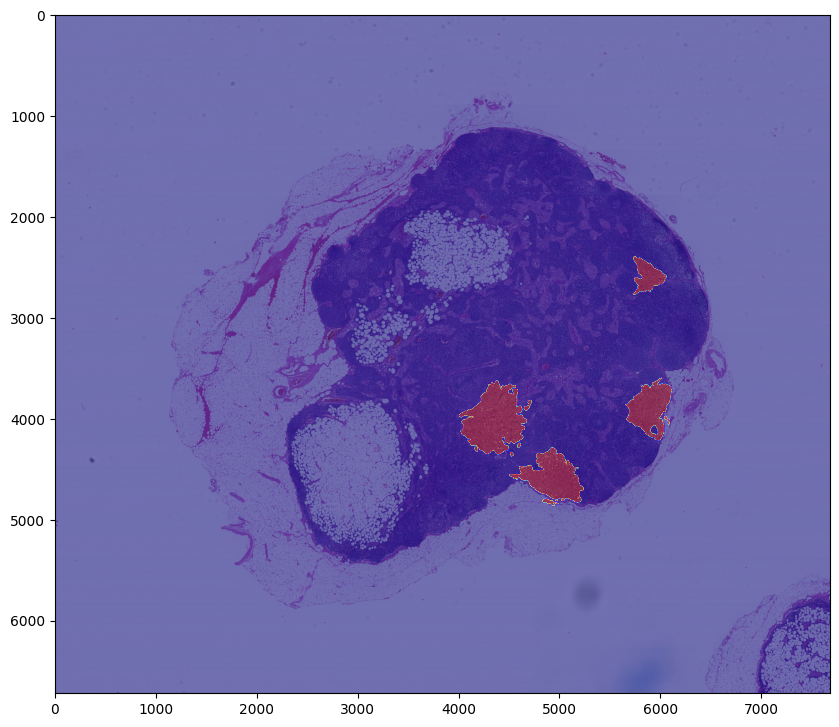

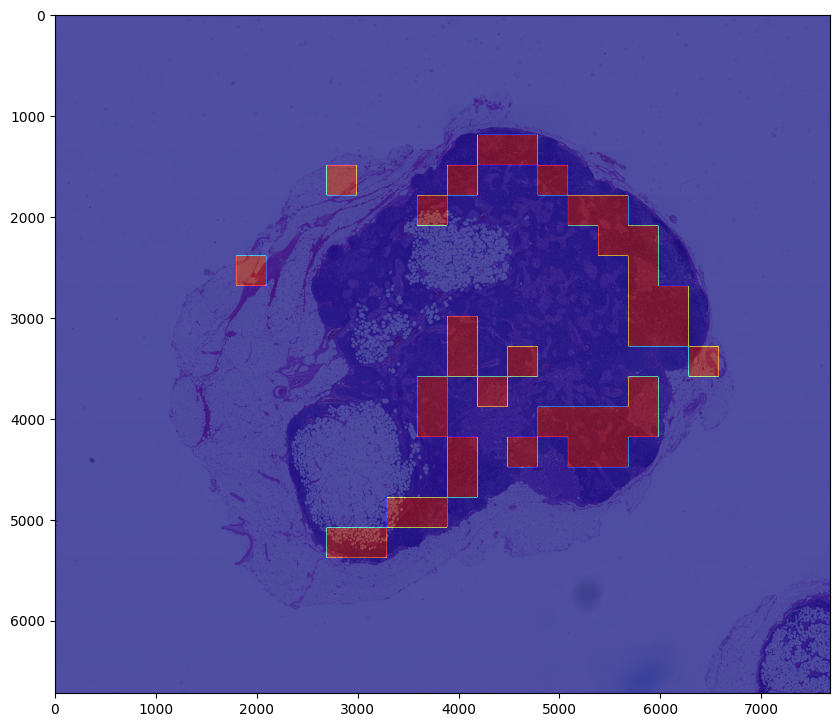

In [44]:
slide_number = 91 
model_inputs = 1
model_name = "Inceptionv3_single_patch_12_24_07_48.h5"

predictions,Y_test_data = get_predictions(model_inputs, model_name, tumor_dictionary, slide_number)

fpr, tpr, thresholds = metrics.roc_curve(Y_test_data,predictions)
best_threshold = thresholds[np.argmin(abs(tpr-(1-fpr)))]

binary_predictions = np.where(predictions < best_threshold , 0 , 1)

print(f"The Accuracy of Model {model_name} on Slide Number is {slide_number} is {metrics.accuracy_score(Y_test_data,binary_predictions)}")
print(f"The Precision of Model {model_name} on Slide Number is {slide_number} is {metrics.precision_score(Y_test_data,binary_predictions)}")
print(f"The Recall of Model {model_name} on Slide Number is {slide_number} is {metrics.recall_score(Y_test_data,binary_predictions)}")
print(f"The F1-Score of Model {model_name} on Slide Number is {slide_number} is {metrics.f1_score(Y_test_data,binary_predictions)}")

np.save(os.path.join("/content/gdrive/MyDrive/Applied_DL_Project/model_predictions",f"predictions_{slide_number}_{model_inputs}_{model_name}.npy"),predictions)

slide = open_slide(tumor_dictionary[slide_number]['tumor'])
tumor_mask = open_slide(tumor_dictionary[slide_number]['mask'])

level = 3
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])

mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])

mask_image = mask_image[:,:,0]

prediction_image = get_prediction_image(slide,level,mask_image,predictions,threshold=best_threshold)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.



plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(prediction_image, cmap='jet', alpha=0.65) # Red regions contains cancer.

Starting prediction for 1794 patches
Prediction complete for 100 patches
Prediction complete for 200 patches
Prediction complete for 300 patches
Prediction complete for 400 patches
Prediction complete for 500 patches
Prediction complete for 600 patches
Prediction complete for 700 patches
Prediction complete for 800 patches
Prediction complete for 900 patches
Prediction complete for 1000 patches
Prediction complete for 1100 patches
Prediction complete for 1200 patches
Prediction complete for 1400 patches
Prediction complete for 1500 patches
Prediction complete for 1600 patches
Prediction complete for 1700 patches
The Accuracy of Model Inceptionv3_single_patch_12_24_07_48.h5 on Slide Number is 78 is 0.8656633221850614
The Precision of Model Inceptionv3_single_patch_12_24_07_48.h5 on Slide Number is 78 is 0.5738758029978587
The Recall of Model Inceptionv3_single_patch_12_24_07_48.h5 on Slide Number is 78 is 0.864516129032258
The F1-Score of Model Inceptionv3_single_patch_12_24_07_48.h5 on

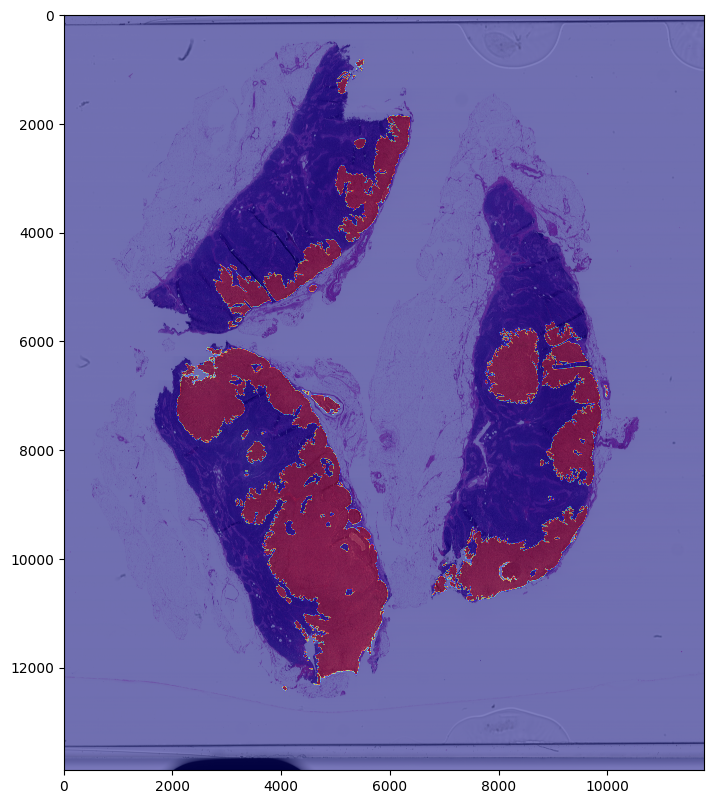

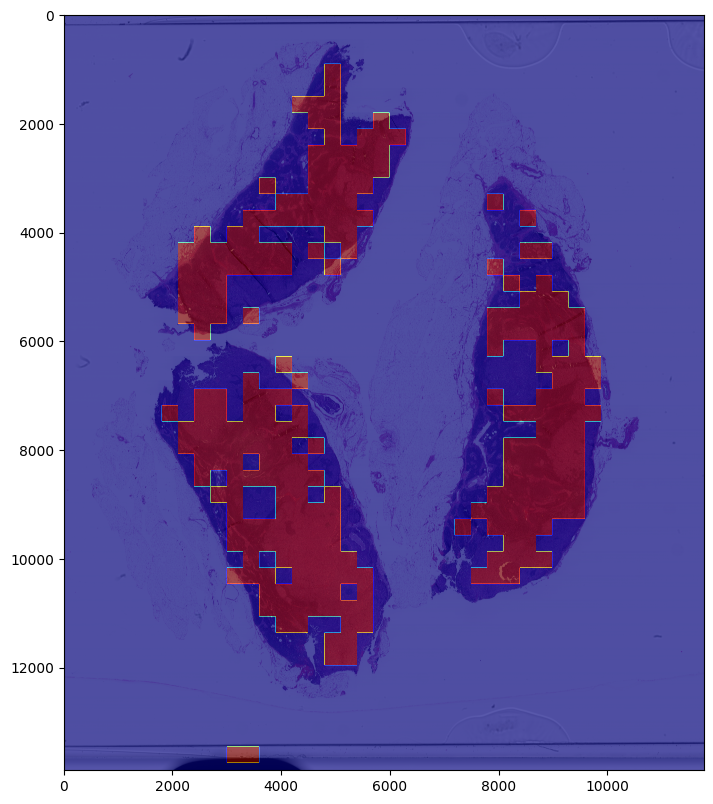

In [18]:
slide_number = 78 
model_inputs = 1
model_name = "Inceptionv3_single_patch_12_24_07_48.h5"

predictions,Y_test_data = get_predictions(model_inputs, model_name, tumor_dictionary, slide_number)

fpr, tpr, thresholds = metrics.roc_curve(Y_test_data,predictions)
best_threshold = thresholds[np.argmin(abs(tpr-(1-fpr)))]

binary_predictions = np.where(predictions < best_threshold , 0 , 1)

print(f"The Accuracy of Model {model_name} on Slide Number is {slide_number} is {metrics.accuracy_score(Y_test_data,binary_predictions)}")
print(f"The Precision of Model {model_name} on Slide Number is {slide_number} is {metrics.precision_score(Y_test_data,binary_predictions)}")
print(f"The Recall of Model {model_name} on Slide Number is {slide_number} is {metrics.recall_score(Y_test_data,binary_predictions)}")
print(f"The F1-Score of Model {model_name} on Slide Number is {slide_number} is {metrics.f1_score(Y_test_data,binary_predictions)}")


np.save(os.path.join("/content/gdrive/MyDrive/Applied_DL_Project/model_predictions",f"predictions_{slide_number}_{model_inputs}_{model_name}.npy"),predictions)

slide = open_slide(tumor_dictionary[slide_number]['tumor'])
tumor_mask = open_slide(tumor_dictionary[slide_number]['mask'])

level = 3
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])

mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])

mask_image = mask_image[:,:,0]
prediction_image = get_prediction_image(slide,level,mask_image,predictions,threshold=best_threshold)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.



plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(prediction_image, cmap='jet', alpha=0.65) # Red regions contains cancer.

The Accuracy of Model Inceptionv3_single_patch_12_24_07_48.h5 on Slide Number is 57 is 0.9657608695652173
The Precision of Model Inceptionv3_single_patch_12_24_07_48.h5 on Slide Number is 57 is 0.05263157894736842
The Recall of Model Inceptionv3_single_patch_12_24_07_48.h5 on Slide Number is 57 is 1.0
The F1-Score of Model Inceptionv3_single_patch_12_24_07_48.h5 on Slide Number is 57 is 0.1


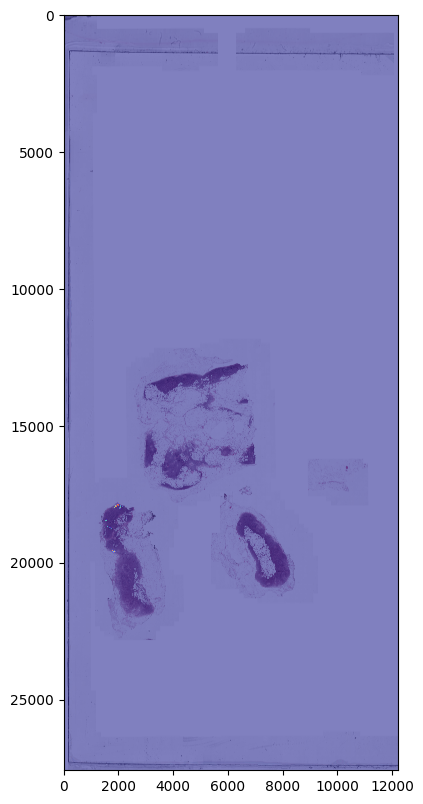

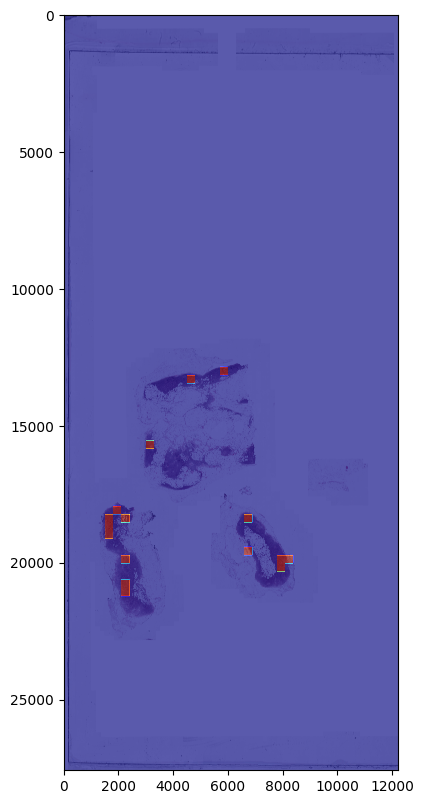

In [20]:
slide_number = 57 
model_inputs = 1
model_name = "Inceptionv3_single_patch_12_24_07_48.h5"

predictions,Y_test_data = get_predictions(model_inputs, model_name, tumor_dictionary, slide_number)

fpr, tpr, thresholds = metrics.roc_curve(Y_test_data,predictions)
best_threshold = thresholds[np.argmin(abs(tpr-(1-fpr)))]

binary_predictions = np.where(predictions < best_threshold , 0 , 1)

print(f"The Accuracy of Model {model_name} on Slide Number is {slide_number} is {metrics.accuracy_score(Y_test_data,binary_predictions)}")
print(f"The Precision of Model {model_name} on Slide Number is {slide_number} is {metrics.precision_score(Y_test_data,binary_predictions)}")
print(f"The Recall of Model {model_name} on Slide Number is {slide_number} is {metrics.recall_score(Y_test_data,binary_predictions)}")
print(f"The F1-Score of Model {model_name} on Slide Number is {slide_number} is {metrics.f1_score(Y_test_data,binary_predictions)}")

np.save(os.path.join("/content/gdrive/MyDrive/Applied_DL_Project/model_predictions",f"predictions_{slide_number}_{model_inputs}_{model_name}.npy"),predictions)

slide = open_slide(tumor_dictionary[slide_number]['tumor'])
tumor_mask = open_slide(tumor_dictionary[slide_number]['mask'])

level = 3
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])

mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])

mask_image = mask_image[:,:,0]
prediction_image = get_prediction_image(slide,level,mask_image,predictions,threshold=best_threshold)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.



plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(prediction_image, cmap='jet', alpha=0.65) # Red regions contains cancer.

### Model-2 Evaluation

In [21]:
model_inputs = 2
model_name = "Inceptionv3_two_patch_12_27_19_30.h5"

In [ ]:
slide_number = 91 

predictions,Y_test_data = get_predictions(model_inputs, model_name, tumor_dictionary, slide_number)

fpr, tpr, thresholds = metrics.roc_curve(Y_test_data,predictions)
best_threshold = thresholds[np.argmin(abs(tpr-(1-fpr)))]

binary_predictions = np.where(predictions < best_threshold , 0 , 1)

print(f"The Accuracy of Model {model_name} on Slide Number is {slide_number} is {metrics.accuracy_score(Y_test_data,binary_predictions)}")
print(f"The Precision of Model {model_name} on Slide Number is {slide_number} is {metrics.precision_score(Y_test_data,binary_predictions)}")
print(f"The Recall of Model {model_name} on Slide Number is {slide_number} is {metrics.recall_score(Y_test_data,binary_predictions)}")
print(f"The F1-Score of Model {model_name} on Slide Number is {slide_number} is {metrics.f1_score(Y_test_data,binary_predictions)}")


np.save(os.path.join("/content/gdrive/MyDrive/Applied_DL_Project/model_predictions",f"predictions_{slide_number}_{model_inputs}_{model_name}.npy"),predictions)

slide = open_slide(tumor_dictionary[slide_number]['tumor'])
tumor_mask = open_slide(tumor_dictionary[slide_number]['mask'])

level = 3
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])

mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])

mask_image = mask_image[:,:,0]

prediction_image = get_prediction_image(slide,level,mask_image,predictions,threshold=best_threshold)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.



plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(prediction_image, cmap='jet', alpha=0.65) # Red regions contains cancer.

Starting prediction for 550 patches
Prediction complete for 100 patches
Prediction complete for 200 patches
Prediction complete for 300 patches
Prediction complete for 400 patches


In [ ]:
slide_number = 78 


predictions,Y_test_data = get_predictions(model_inputs, model_name, tumor_dictionary, slide_number)

fpr, tpr, thresholds = metrics.roc_curve(Y_test_data,predictions)
best_threshold = thresholds[np.argmin(abs(tpr-(1-fpr)))]

binary_predictions = np.where(predictions < best_threshold , 0 , 1)

print(f"The Accuracy of Model {model_name} on Slide Number is {slide_number} is {metrics.accuracy_score(Y_test_data,binary_predictions)}")
print(f"The Precision of Model {model_name} on Slide Number is {slide_number} is {metrics.precision_score(Y_test_data,binary_predictions)}")
print(f"The Recall of Model {model_name} on Slide Number is {slide_number} is {metrics.recall_score(Y_test_data,binary_predictions)}")
print(f"The F1-Score of Model {model_name} on Slide Number is {slide_number} is {metrics.f1_score(Y_test_data,binary_predictions)}")


np.save(os.path.join("/content/gdrive/MyDrive/Applied_DL_Project/model_predictions",f"predictions_{slide_number}_{model_inputs}_{model_name}.npy"),predictions)

slide = open_slide(tumor_dictionary[slide_number]['tumor'])
tumor_mask = open_slide(tumor_dictionary[slide_number]['mask'])

level = 3
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])

mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])

mask_image = mask_image[:,:,0]

prediction_image = get_prediction_image(slide,level,mask_image,predictions,threshold=best_threshold)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.



plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(prediction_image, cmap='jet', alpha=0.65) # Red regions contains cancer.

In [ ]:
slide_number = 57 


predictions,Y_test_data = get_predictions(model_inputs, model_name, tumor_dictionary, slide_number)

fpr, tpr, thresholds = metrics.roc_curve(Y_test_data,predictions)
best_threshold = thresholds[np.argmin(abs(tpr-(1-fpr)))]

binary_predictions = np.where(predictions < best_threshold , 0 , 1)

print(f"The Accuracy of Model {model_name} on Slide Number is {slide_number} is {metrics.accuracy_score(Y_test_data,binary_predictions)}")
print(f"The Precision of Model {model_name} on Slide Number is {slide_number} is {metrics.precision_score(Y_test_data,binary_predictions)}")
print(f"The Recall of Model {model_name} on Slide Number is {slide_number} is {metrics.recall_score(Y_test_data,binary_predictions)}")
print(f"The F1-Score of Model {model_name} on Slide Number is {slide_number} is {metrics.f1_score(Y_test_data,binary_predictions)}")

np.save(os.path.join("/content/gdrive/MyDrive/Applied_DL_Project/model_predictions",f"predictions_{slide_number}_{model_inputs}_{model_name}.npy"),predictions)

slide = open_slide(tumor_dictionary[slide_number]['tumor'])
tumor_mask = open_slide(tumor_dictionary[slide_number]['mask'])

level = 3
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])

mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])

mask_image = mask_image[:,:,0]

prediction_image = get_prediction_image(slide,level,mask_image,predictions,threshold=best_threshold)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.



plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(prediction_image, cmap='jet', alpha=0.65) # Red regions contains cancer.

### Model - 3 

In [ ]:
model_inputs = 3
model_name = "Inceptionv3_three_patch_12_27_22_00.h5"

In [ ]:
slide_number = 91 

predictions,Y_test_data = get_predictions(model_inputs, model_name, tumor_dictionary, slide_number)

fpr, tpr, thresholds = metrics.roc_curve(Y_test_data,predictions)
best_threshold = thresholds[np.argmin(abs(tpr-(1-fpr)))]

binary_predictions = np.where(predictions < best_threshold , 0 , 1)

print(f"The Accuracy of Model {model_name} on Slide Number is {slide_number} is {metrics.accuracy_score(Y_test_data,binary_predictions)}")
print(f"The Precision of Model {model_name} on Slide Number is {slide_number} is {metrics.precision_score(Y_test_data,binary_predictions)}")
print(f"The Recall of Model {model_name} on Slide Number is {slide_number} is {metrics.recall_score(Y_test_data,binary_predictions)}")
print(f"The F1-Score of Model {model_name} on Slide Number is {slide_number} is {metrics.f1_score(Y_test_data,binary_predictions)}")


np.save(os.path.join("/content/gdrive/MyDrive/Applied_DL_Project/model_predictions",f"predictions_{slide_number}_{model_inputs}_{model_name}.npy"),predictions)

slide = open_slide(tumor_dictionary[slide_number]['tumor'])
tumor_mask = open_slide(tumor_dictionary[slide_number]['mask'])

level = 3
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])

mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])

mask_image = mask_image[:,:,0]

prediction_image = get_prediction_image(slide,level,mask_image,predictions,threshold=best_threshold)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.



plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(prediction_image, cmap='jet', alpha=0.65) # Red regions contains cancer.

In [ ]:
slide_number = 78 

predictions,Y_test_data = get_predictions(model_inputs, model_name, tumor_dictionary, slide_number)

fpr, tpr, thresholds = metrics.roc_curve(Y_test_data,predictions)
best_threshold = thresholds[np.argmin(abs(tpr-(1-fpr)))]

binary_predictions = np.where(predictions < best_threshold , 0 , 1)

print(f"The Accuracy of Model {model_name} on Slide Number is {slide_number} is {metrics.accuracy_score(Y_test_data,binary_predictions)}")
print(f"The Precision of Model {model_name} on Slide Number is {slide_number} is {metrics.precision_score(Y_test_data,binary_predictions)}")
print(f"The Recall of Model {model_name} on Slide Number is {slide_number} is {metrics.recall_score(Y_test_data,binary_predictions)}")
print(f"The F1-Score of Model {model_name} on Slide Number is {slide_number} is {metrics.f1_score(Y_test_data,binary_predictions)}")


np.save(os.path.join("/content/gdrive/MyDrive/Applied_DL_Project/model_predictions",f"predictions_{slide_number}_{model_inputs}_{model_name}.npy"),predictions)

slide = open_slide(tumor_dictionary[slide_number]['tumor'])
tumor_mask = open_slide(tumor_dictionary[slide_number]['mask'])

level = 3
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])

mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])

mask_image = mask_image[:,:,0]

prediction_image = get_prediction_image(slide,level,mask_image,predictions,threshold=best_threshold)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.



plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(prediction_image, cmap='jet', alpha=0.65) # Red regions contains cancer.

In [ ]:
slide_number = 57 

predictions,Y_test_data = get_predictions(model_inputs, model_name, tumor_dictionary, slide_number)

fpr, tpr, thresholds = metrics.roc_curve(Y_test_data,predictions)
best_threshold = thresholds[np.argmin(abs(tpr-(1-fpr)))]

binary_predictions = np.where(predictions < best_threshold , 0 , 1)

print(f"The Accuracy of Model {model_name} on Slide Number is {slide_number} is {metrics.accuracy_score(Y_test_data,binary_predictions)}")
print(f"The Precision of Model {model_name} on Slide Number is {slide_number} is {metrics.precision_score(Y_test_data,binary_predictions)}")
print(f"The Recall of Model {model_name} on Slide Number is {slide_number} is {metrics.recall_score(Y_test_data,binary_predictions)}")
print(f"The F1-Score of Model {model_name} on Slide Number is {slide_number} is {metrics.f1_score(Y_test_data,binary_predictions)}")


np.save(os.path.join("/content/gdrive/MyDrive/Applied_DL_Project/model_predictions",f"predictions_{slide_number}_{model_inputs}_{model_name}.npy"),predictions)

slide = open_slide(tumor_dictionary[slide_number]['tumor'])
tumor_mask = open_slide(tumor_dictionary[slide_number]['mask'])

level = 3
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])

mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])

mask_image = mask_image[:,:,0]

prediction_image = get_prediction_image(slide,level,mask_image,predictions,threshold=best_threshold)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.



plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(prediction_image, cmap='jet', alpha=0.65) # Red regions contains cancer.